<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/42_hier_gaussian.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_gaussian_model)=
# Modello gerarchico gaussiano

In questo capitolo, proseguiremo la discussione sul modello gerarchico bayesiano utilizzando PyMC, concentrandoci questa volta sul caso in cui i dati seguono una distribuzione gaussiana.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Preparazione del notebook


Per discutere il modello gerarchico gaussiano, utilizzeremo nuovamente i dati relativi ai pinguini Palmer. 

In [8]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

## Modellizzazione bayesiana

Il modello che abbiamo usato nel capitolo {ref}`groups_comparison_notebook` non è un modello gerarchico, poiché $ \mu $ e $ \sigma $ sono stimati in modo indipendente per ciascuna delle tre specie. In un modello gerarchico, è necessario un livello "superiore" di parametri che influenzano i parametri $ \mu $ e $ \sigma $ per ciascuna specie, permettendo la condivisione delle informazioni tra le diverse specie. In altre parole, in un modello gerarchico, i parametri $ \mu $ e $ \sigma $ per ciascuna specie vengono a loro volta modellati come estrazioni da una distribuzione "superiore", il che permette un certo grado di pooling delle informazioni tra le diverse specie.

In [10]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as hierarchical_model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Hyperpriors
    mu_mean = pm.Normal("mu_mean", 4200, 1000)
    mu_sd = pm.HalfNormal("mu_sd", 500)
    sigma_mean = pm.HalfNormal("sigma_mean", 500)
    sigma_sd = pm.HalfNormal("sigma_sd", 100)
    
    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", mu_mean, mu_sd, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=sigma_mean, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

In questo modello gerarchico, `mu_mean` e `mu_sd` fungono da iperparametri per la distribuzione a priori di $ \mu $, mentre `sigma_mean` e `sigma_sd` servono come iperparametri per la distribuzione a priori di $ \sigma $. Gli iperparametri facilitano il "pooling parziale" delle informazioni tra le diverse categorie di specie, permettendo una condivisione strutturale delle informazioni nel modello. Questo pooling parziale consente di effettuare inferenze più robuste, specialmente quando la dimensione del campione per una determinata categoria è limitata.

Visualizziamo la struttura del modello.

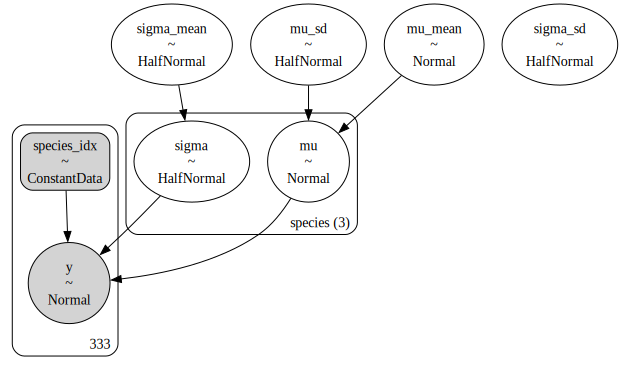

In [11]:
pm.model_to_graphviz(hierarchical_model)

Eseguiamo il controllo predittivo a priori.

In [21]:
with hierarchical_model:
    idata_pooling_prior_pred = pm.sample_prior_predictive(random_seed=rng)

Sampling: [mu, mu_mean, mu_sd, sigma, sigma_mean, sigma_sd, y]


In [22]:
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y
flattened_array = np.ravel(likelihood_samples.values)

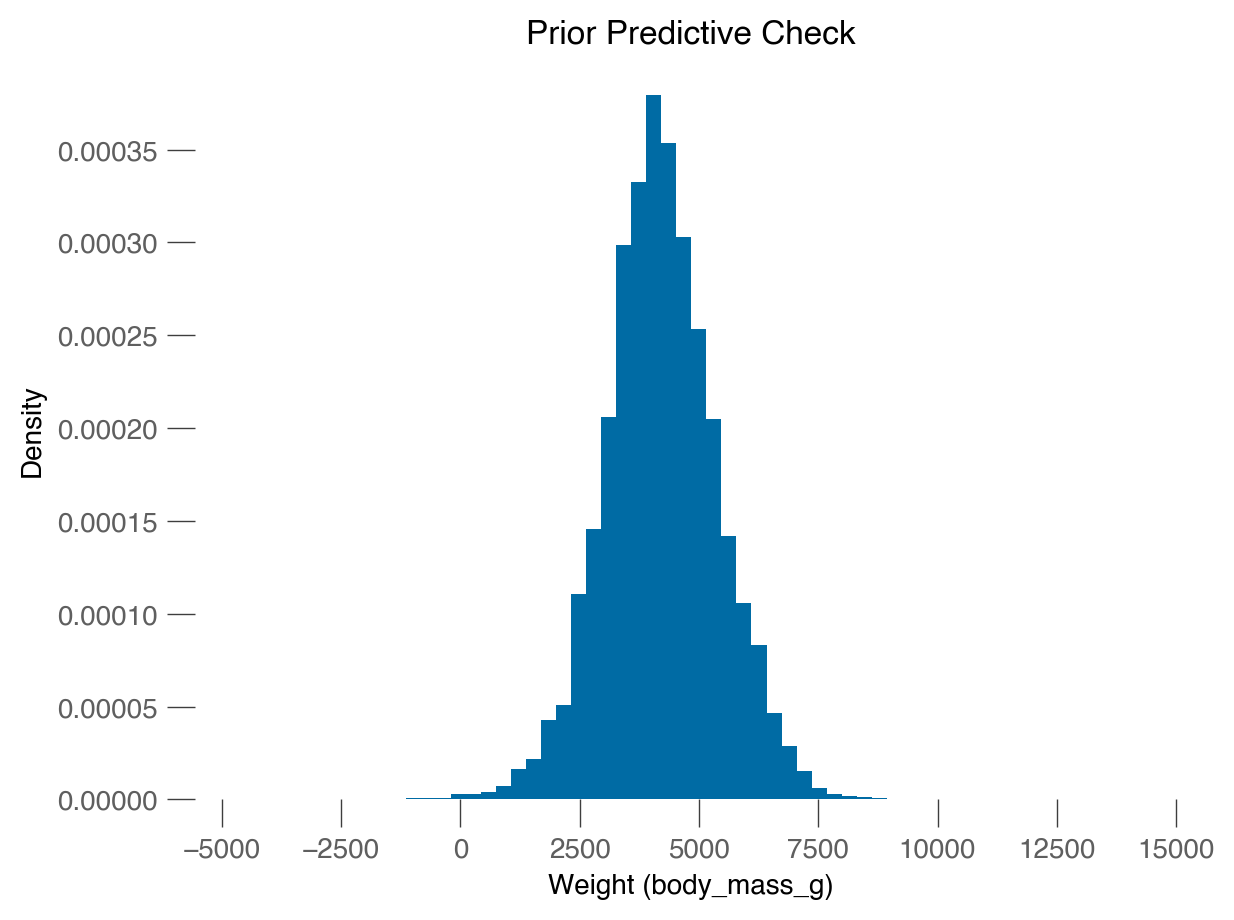

In [25]:
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Weight (body_mass_g)')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.show()

Eseguiamo il campionamento.

In [12]:
with hierarchical_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:10.650330
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:05<?, ?it/s]



Running chain 0:   5%|▌         | 100/2000 [00:06<00:12, 146.35it/s]


Running chain 0:  45%|████▌     | 900/2000 [00:06<00:00, 1492.85it/s]


Running chain 0:  90%|█████████ | 1800/2000 [00:06<00:00, 2960.75it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:06<00:00, 291.23it/s] 


Sampling time =  0:00:07.531331
Transforming variables...
Transformation time =  0:00:00.064912
Computing Log Likelihood...
Log Likelihood time =  0:00:00.661170


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

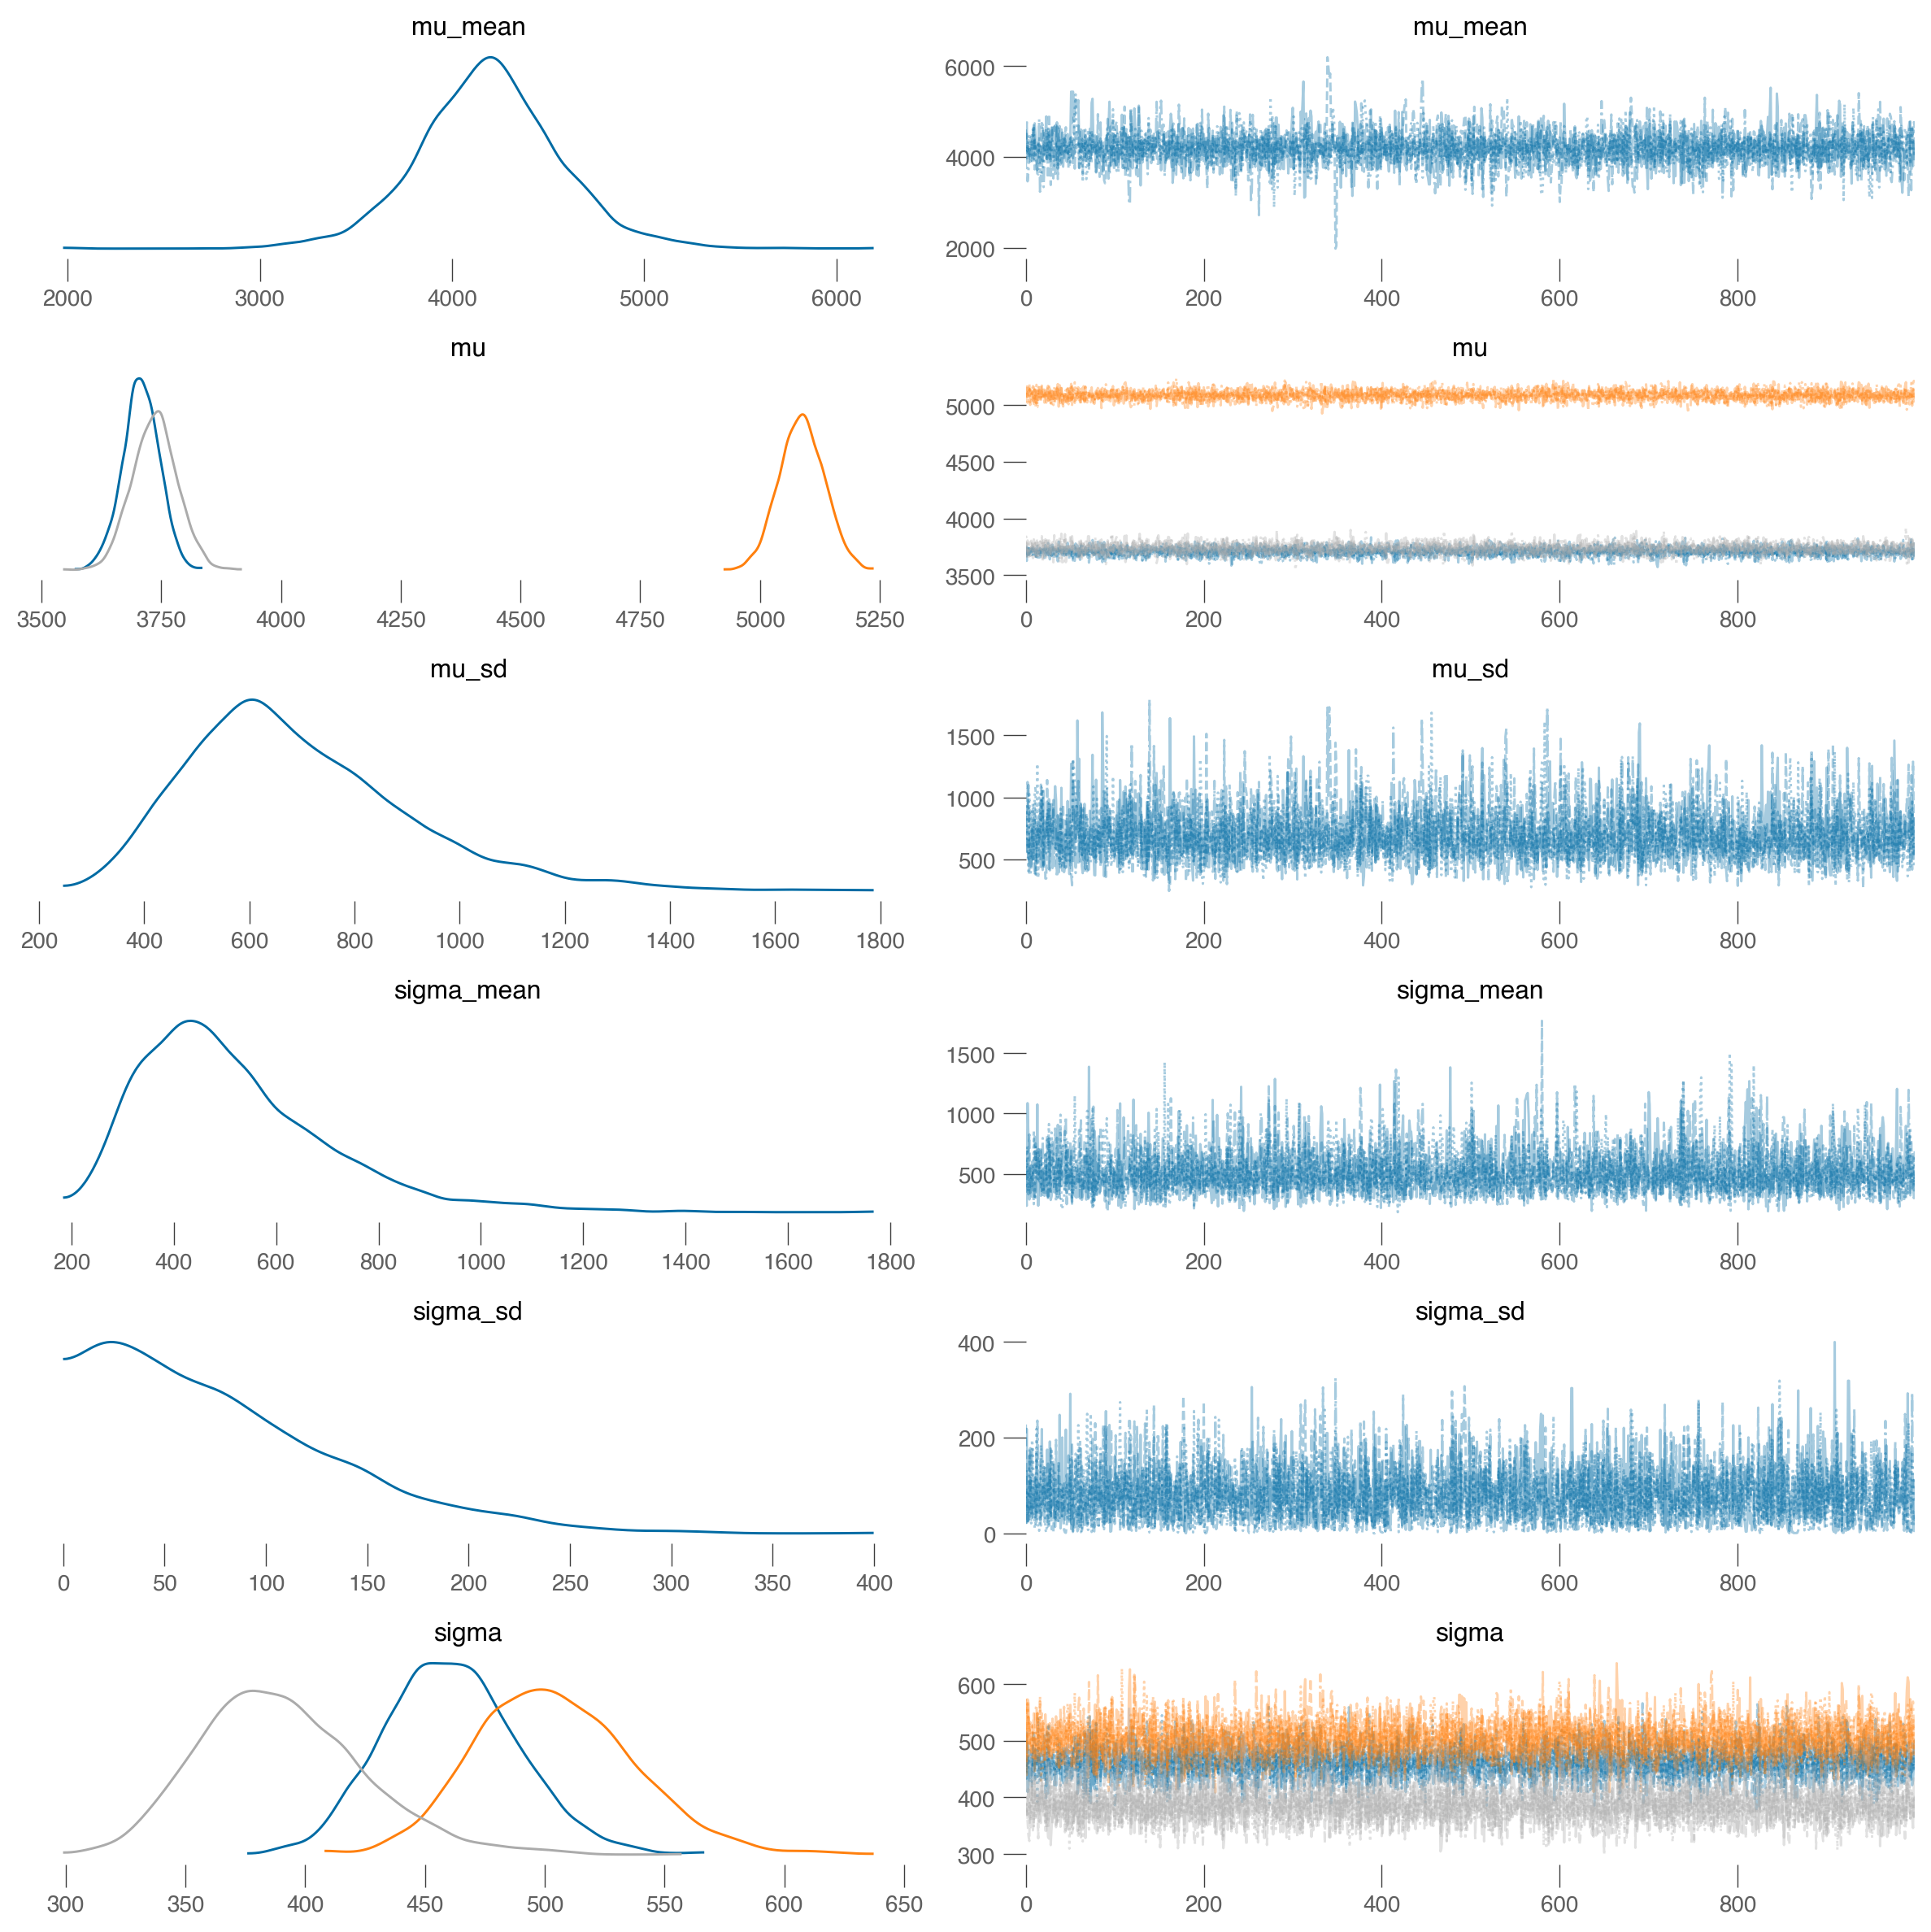

In [14]:
az.plot_trace(idata, combined=True)
plt.tight_layout()
plt.show()

Creiamo un sommario numerico.

In [26]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_mean,4191.570,373.424,3509.086,4920.005,6.713,4.854,3335.0,2452.0,1.0
mu[Adelie],3707.406,38.134,3633.493,3778.273,0.540,0.382,5024.0,2728.0,1.0
mu[Gentoo],5087.236,46.446,4998.121,5172.296,0.691,0.489,4521.0,2667.0,1.0
mu[Chinstrap],3736.249,46.858,3650.063,3825.975,0.634,0.448,5460.0,2496.0,1.0
mu_sd,696.225,217.870,327.736,1100.002,3.662,2.720,3884.0,3244.0,1.0
sigma_mean,517.339,188.735,227.516,863.373,2.905,2.196,4764.0,3082.0,1.0
sigma_sd,78.680,59.168,0.118,186.204,0.872,0.633,3310.0,1943.0,1.0
sigma[Adelie],460.852,27.760,407.734,511.226,0.420,0.302,4726.0,2495.0,1.0
sigma[Gentoo],504.031,32.896,438.611,561.358,0.509,0.364,4320.0,2876.0,1.0
sigma[Chinstrap],389.882,34.243,330.169,455.254,0.523,0.377,4543.0,2519.0,1.0


Nel confronto tra le stime della media del peso per le tre specie di pinguini ottenute dal modello gerarchico e quelle derivanti dal modello indipendente, osserviamo un effetto di "shrinkage". In particolare, le stime delle medie specifiche per ogni specie nel modello gerarchico tendono a convergere leggermente verso la media globale del peso, pari a 4191.570 g. Questo è in contrasto con le stime ottenute dal modello che considera le tre specie come indipendenti:

- $ \mu_{\text{Adelie}} = 3707.643 $ 
- $ \mu_{\text{Gentoo}} = 5091.668 $ 
- $ \mu_{\text{Chinstrap}} = 3733.534 $

Questo fenomeno di shrinkage è una caratteristica distintiva dei modelli gerarchici e indica una maggiore robustezza delle stime, specialmente quando la dimensione del campione per una o più categorie è relativamente piccola.

In [ ]:
var_names=["mu_mean", "mu"]
az.plot_forest(idata, var_names=var_names, combined=True)
obs_mean=hierarchical_model["y"].eval().mean()
plt.axvline(x = obs_mean, color = 'black', alpha=0.1)
plt.show()

Valutiamo il modello mediante un controllo predittivo a posteriori (Posterior Predictive Check, PPC). Questa tecnica prevede la generazione di dati simulati dal modello, utilizzando i parametri estratti dalle distribuzioni a posteriori, per poi confrontare queste simulazioni con i dati osservati. Questo processo permette di verificare quanto accuratamente il modello riesca a riprodurre le caratteristiche dei dati e, di conseguenza, la sua adeguatezza.

In [18]:
with hierarchical_model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [y]


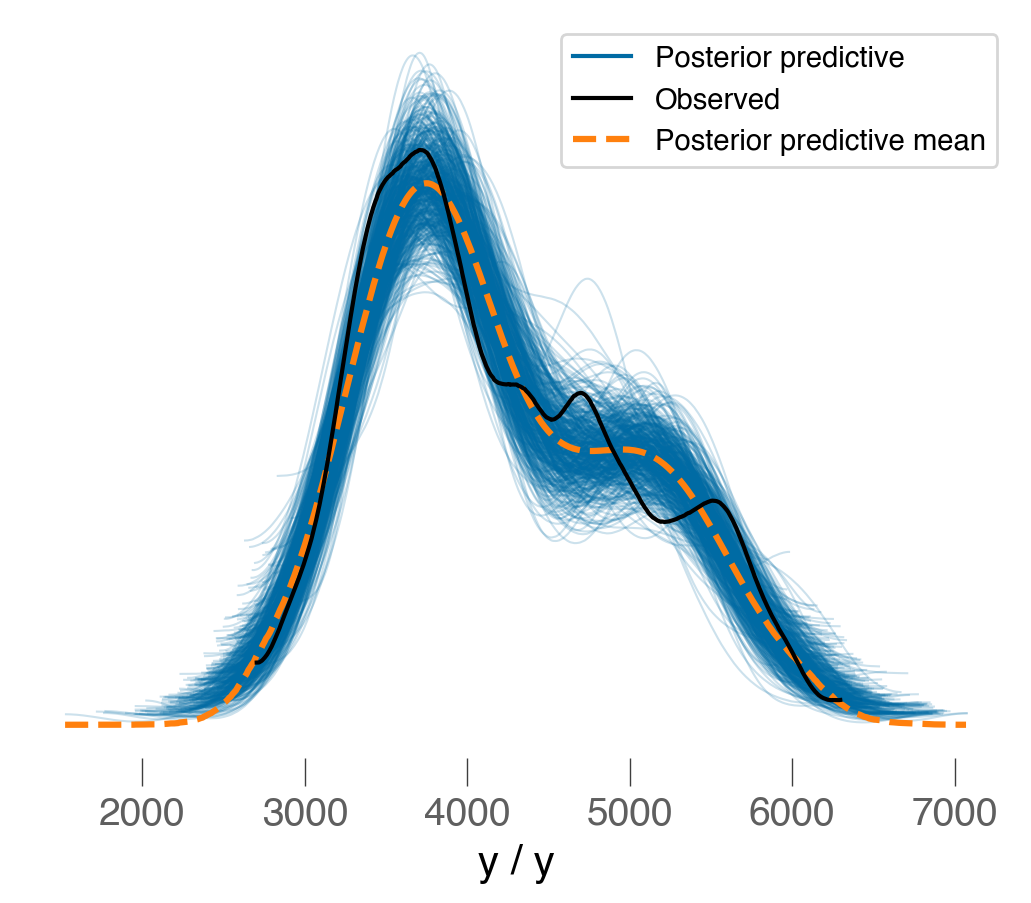

In [19]:
az.plot_ppc(post_pred, num_pp_samples=500)
plt.show()

L'adattamento del modello ai dati è molto buono.

Calcoliamo ora la Expected Log Predictive Density (ELPD) e la diagnostica Pareto $k$.

In [20]:
m_loo = az.loo(idata)
m_loo

Computed from 4000 posterior samples and 333 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2516.17    11.69
p_loo        5.48        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      333  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

La metrica diagnostica Pareto $k$ non indica la presenza di valori anomali o outlier nel set di dati.

## Watermark

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Aug 30 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

pytensor: 2.14.2

bambi     : 0.12.0
numpy     : 1.25.2
matplotlib: 3.7.2
pandas    : 2.0.3
seaborn   : 0.12.2
scipy     : 1.11.2
arviz     : 0.16.1
pymc      : 5.7.2

Watermark: 2.4.3

